In [1]:
import io
import torch
import torchaudio
import torchvision
import numpy as np
from datasets import load_dataset
from IPython.display import display, Audio, Image, update_display, HTML
from torchvision.transforms import ToPILImage
from fastprogress.fastprogress import master_bar, progress_bar

/home/dgj335/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
device = "cuda"
class Config: pass
config = Config()
config.batch_size = 16
config.num_workers = 12
config.grad_accum_steps = 1
config.plot_update = 64
config.patience = 64
config.min_lr = 1e-7
config.max_lr = 3e-5
config.warmup_steps = 5000
config.weight_decay = 0.
config.epochs = 10000

config.length_samples = 2**20
config.channels = 2
config.embed_dim = 192
config.patch_size = 4096
config.depth = 12

In [3]:
train_dataset = load_dataset("danjacobellis/musdb18hq_vss",split='train')
valid_dataset = load_dataset("danjacobellis/musdb18hq_vss",split='validation')

In [4]:
L = config.length_samples
C = config.channels
crop = torchvision.transforms.RandomCrop((2,L))
def collate_fn(batch):
    B = len(batch)
    x = torch.zeros( (B, C, 2, L), dtype=torch.float32)
    i_sample = 0
    for i_sample, sample in enumerate(batch):
        audio_mix, fs = torchaudio.load(sample['audio_mix']['bytes'])
        audio_vocal, fs = torchaudio.load(sample['audio_vocal']['bytes'])
        audio_mix = audio_mix.unsqueeze(1)
        audio_vocal = audio_vocal.unsqueeze(1)
        audio = torch.cat([audio_mix,audio_vocal],dim=1)
        x[i_sample,:,:,:] = crop(audio)
    return x[:,:,0,:], x[:,:,1,:]

In [5]:
valid_batch = valid_dataset[:4]
valid_batch = [dict(zip(valid_batch.keys(), values)) for values in zip(*valid_batch.values())]
x_valid, v_valid = collate_fn(valid_batch)
x_valid = x_valid.to(device)
v_valid = v_valid.to(device)

In [6]:
def make_spectrogram(X):
    X = spectrogram(X).log()
    X = X - X.mean()
    X = X/X.std()
    X = X/3
    X = X.clamp(-0.5,0.5)
    X = X + 0.5
    return ToPILImage()(X)

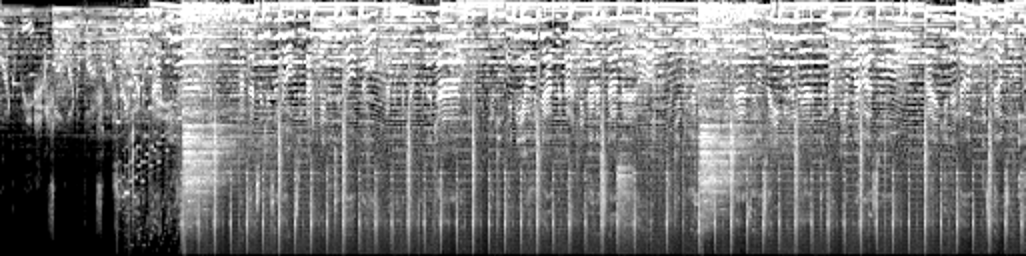

In [7]:
spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=44100,
    n_fft=4096,
).to(device)
SG = make_spectrogram(x_valid[0,0].to(device))
SG.resize((1026,256))

In [8]:
import torch
import torch.nn as nn
from einops import rearrange

class AudioCNN(nn.Module):
    def __init__(self, channels, embed_dim, patch_size, depth):
        super(AudioCNN, self).__init__()
        self.channels = channels
        self.embed_dim = embed_dim
        self.patch_size = patch_size
        self.depth = depth

        self.conv_stem = nn.Conv1d(
            in_channels=self.channels,
            out_channels=self.embed_dim,
            kernel_size=self.patch_size,
            stride=self.patch_size,
            padding=0,
        )

        self.conv_layers = nn.ModuleList([
            nn.Conv1d(
                in_channels=self.embed_dim,
                out_channels=self.embed_dim,
                kernel_size=11,
                stride=1,
                padding=5,
                padding_mode='reflect'
            ) for _ in range(self.depth)
        ])

        self.linear_projection = nn.Linear(self.embed_dim, self.patch_size * self.channels)
        self.clamp = nn.Hardtanh(min_val=-1.0, max_val=1.0)


    def forward(self, x):
        x = self.conv_stem(x)
        for conv_layer in self.conv_layers:
            residual = x
            x = conv_layer(x)
            x = x + residual
        x = rearrange(x, 'b c l -> b l c')
        x = self.linear_projection(x)
        x = self.clamp(x)
        x = rearrange(x, 'b l (p c) -> b c (l p)', p=self.patch_size, c=self.channels)
        return x


In [9]:
model = AudioCNN(
    channels = config.channels,
    embed_dim = config.embed_dim,
    patch_size = config.patch_size,
    depth = config.depth
).to(device)

optimizer = torch.optim.AdamW(
    params=model.parameters(),
    weight_decay=0.0,
    lr = config.min_lr
)

sum(p.numel() for p in model.parameters())/1e6

8.022464

In [10]:
def minus_cosine_warmup(i_step):
    scale = 0.5 * (np.log10(config.max_lr) - np.log10(config.min_lr))
    angle =  np.pi * i_step / (config.warmup_steps//config.plot_update)
    log_lr = np.log10(config.min_lr) + scale * (1 - np.cos(angle))
    lr = 10 ** log_lr
    return lr/config.min_lr
    
warmup = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda = lambda i_step: minus_cosine_warmup(i_step)
)

reduce_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    factor=0.98,
    patience=config.patience,
    threshold=1e-5,
    min_lr=config.min_lr
)

/home/dgj335/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


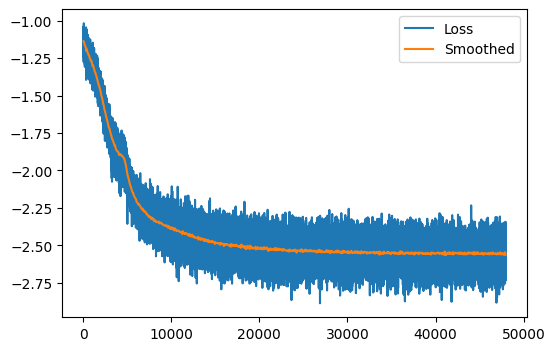

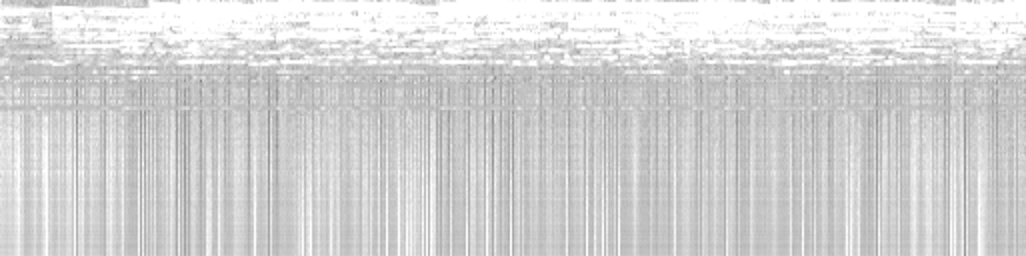


KeyboardInterrupt



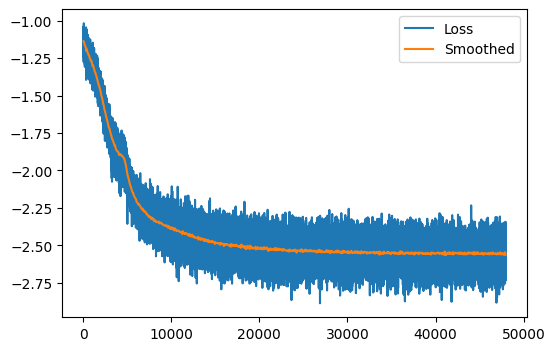

In [11]:
losses = []
learning_rates = [optimizer.param_groups[0]['lr']]
img_displays = []
text_display = None
model.train()
optimizer.zero_grad()
mb = master_bar(range(config.epochs))
mb.names = ['Loss', 'Smoothed']
i_step = 0
for i_epoch in mb:
    dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        num_workers=config.num_workers,
        drop_last=True,
        shuffle=True,
        collate_fn=collate_fn
    )
   
    for i, (x,v) in enumerate(progress_bar(dataloader, parent=mb)):
        x = x.to(device)
        v = v.to(device)

        pred = model(x)
        mse_loss = torch.nn.functional.mse_loss(pred, x-v)
        losses.append(np.log10(mse_loss.item()))
        mse_loss.backward()
        if (i + 1) % config.grad_accum_steps == 0: 
            optimizer.step()
            optimizer.zero_grad()
        
        # plotting and lr scheduler
        if len(losses) % config.plot_update == 0:
            plot_n = len(losses) // config.plot_update
            smoothed_x = (0.5+torch.arange(plot_n)) * config.plot_update
            smoothed_y = torch.tensor(losses).reshape(plot_n, -1).mean(dim=1)
            dist_x = range(len(losses))
            dist_y = losses
            mb.update_graph([[dist_x, dist_y],[smoothed_x, smoothed_y]])
            mb.child.comment = f'loss {smoothed_y[-1]:.4g}; lr {learning_rates[-1]:.4g}'

            # lr scheduler
            if i_step < config.warmup_steps:
                warmup.step()
            else:
                reduce_plateau.step(smoothed_y[-1])
            learning_rates.append(optimizer.param_groups[0]['lr'])

            with torch.no_grad():
                model.eval()
                y_valid = model(x_valid)[0]
                torchaudio.save(f"valid_{device}.wav", src=y_valid.to("cpu"), sample_rate=44100)
                buffer = io.BytesIO()
                make_spectrogram(y_valid).resize((1026,256)).save(buffer, format="PNG")
                model.train()
            buffer.seek(0)
            if len(img_displays) == 0:
                img_displays.append(display(Image(buffer.read()), display_id=True))
            else:
                update_display(Image(buffer.read()), display_id=img_displays[0].display_id)
        i_step+=1
        
        torch.save({
            'model_state_dict': model.state_dict(),
            'i_epoch': i_epoch,
            'learning_rates': learning_rates,
            'train_loss': losses,
            'config': config
        }, f"log_{device}.pth")